# Hidden Gems in Personalized Information Retrieval  
In this project, we aim to build and evaluate an **advanced retrieval model** that can efficiently find relevant documents based on user queries, with a focus on **information retrieval (IR)** and **recommender systems (RS)**.
The approach integrates multiple stages, including query expansion, document retrieval, ranking and evaluation using **precision**, **nDCG**, and **MAP** as the primary metrics for assessing performance.

Key components of this work include:

1. **Data Preprocessing**: Proper handling of input data (questions, answers and queries) through cleaning and normalization techniques.
   
2. **Indexing and Retrieval**: We employ advanced retrieval models like **BM25** for traditional text-based search and **Bi-Encoder Ranking** with **MiniLM** for an efficient semantic matching.
Both techniques are integrated into a **custom RetrieverModel** class, ensuring flexibility and adaptability to different types of datasets.

3. **Query Expansion**: To broaden search results, we leverage **T5-small** to expand queries dynamically, generating variations that help increase the diversity of search results.
However, it should be noted that **query expansion** may not always improve relevance, as demonstrated by the evaluation, where the expanded queries did not result in higher precision or MAP scores.

4. **Evaluation**: The model's retrieval performance is rigorously evaluated using a set of **qrels** (relevance judgments) and **test data**. Evaluation takes place with and without query expansion, showing its potential impact on retrieval quality.

This **original implementation** is not just a straightforward application of IR techniques, but rather an advanced setup that integrates also query expansion and deep learning models to ensure better retrieval performance. By evaluating the model with real-world data, we demonstrate the effectiveness of this integrated approach in both traditional and cutting-edge information retrieval tasks.

## Highlighting Our Personal Implementation: Hidden Gems in IR

Our project introduces a key innovation in **identifying "Hidden Gems"** in Information Retrieval. Hidden Gems refer to documents that may not be highly ranked in traditional search engines but possess significant relevance and value when analyzed through deeper, personalized, search techniques. They can be viewed as documents appreciated by niche audiences but underexposed to a broader user base, characterized by high favorites-to-view ratios.

In this implementation, we focus on extracting these Hidden Gems by:

- **Personalized Ranking**: By applying **deep semantic matching** via **Bi-Encoder Ranking** with **MiniLM**, we can more accurately identify documents that may have lower traditional search rankings but offer high relevance to specific user needs.
  
- **Expanded Query Search**: The integration of **query expansion** via **T5-small** generates variations of the original query, potentially surfacing more diverse and previously overlooked results.

This **original implementation** of identifying Hidden Gems is a unique aspect of this project, leveraging both traditional and advanced deep learning techniques to provide more personalized and relevant search results.

### Importing Necessary Libraries  
Importing necessary libraries for data processing, retrieval and model inference. GPU acceleration is enabled when available.  

In [1]:
import emoji
import json
import math
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import retriv
import textwrap
import torch

from bs4 import BeautifulSoup
from collections import Counter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\andre\anaconda3\envs\machine-learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data and Text Preprocessing
Handling dataset cleaning and preprocessing to ensure its suitability for the retrieval models. Although the SE-PQA subset is already well-structured, this approach is designed to handle larger datasets that may contain imperfections such as duplicates, missing values or incomplete data. The steps include removing duplicate entries, filling missing values, filtering out questions without answers and extracting relevant features.

In [2]:
file_path = "train/subset_data.jsonl"
df = pd.read_json(path_or_buf=file_path, lines=True)
df_questions = df.copy()

df_questions.head()

,id,text,title,timestamp,score,views,favorite,user_id,user_questions,user_answers,tags,rel_ids,rel_scores,rel_timestamps,best_answer
0,academia_100305,What are CNRS research units and how are they ...,What are CNRS research units and how are they ...,2017-12-11 16:30:20,14,2484,2.0,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[funding, france]",[academia_100217],[1],"[1512814966, 1513014615, 1513020822]",academia_100217
1,academia_100456,Is there a free (as in freedom) alternative to...,Is there a free (as in freedom) alternative to...,2017-12-13 19:02:32,13,1117,2.0,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[peer-review, open-access]",[academia_100462],[1],"[1513205016, 1536615064, 1553005541, 1615097827]",academia_100462
2,academia_103390,Search for StackExchange citations with Google...,Search for StackExchange citations with Google...,2018-02-06 16:40:59,2,157,1.0,1532620,"[writers_27613, writers_29562, sound_42166, so...","[skeptics_39944, philosophy_3098, philosophy_9...","[citations, google-scholar]",[academia_103391],[1],[1517936080],academia_103391
3,academia_10481,Reproducible research and corporate identity M...,Reproducible research and corporate identity,2013-06-06 09:11:05,18,372,1.0,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...","[copyright, creative-commons]",[academia_10499],[1],"[1370596608, 1370601095]",academia_10499
4,academia_10649,Advantages of second marking In the UK a porti...,Advantages of second marking,2013-06-17 12:24:37,6,1235,2.0,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...",[assessment],[academia_10650],[1],"[1371477146, 1371477156, 1371552185]",academia_10650


In [3]:
# Check if there are any duplicate rows
duplicate_documents = df[df.duplicated(subset=['text'], keep=False)]
print("Number of duplicate entries: ", duplicate_documents.shape[0])

# Remove duplicate rows
df_questions = df_questions.drop_duplicates(subset=['text'], keep='first')
df_questions = df_questions.reset_index(drop=True)

# Fill NaN values with 0 in favorites column
df_questions["favorite"] = df_questions["favorite"].fillna(0)
df_questions["favorite"] = df_questions["favorite"].astype(int)

# Remove any questions without answers
df_questions = df_questions[df_questions["best_answer"].apply(lambda x: len(x) > 0)]
df_questions = df_questions.reset_index(drop=True)

# We are only interested in the latest update of the relevance
df_questions["last_update_rel_timestamps"] = df_questions["rel_timestamps"].apply(lambda x: x[-1])

# Remove the columns that are not needed
df_questions = df_questions.drop(["title", "rel_ids", "rel_timestamps"], axis=1)

# Retrieve only the date, without the time
def simplify_timestamp(df):
    df_questions["timestamp"] = pd.to_datetime(df_questions["timestamp"])
    df_questions["date"] = df_questions["timestamp"].dt.date
    return df["date"]

df_questions["date"] = simplify_timestamp(df_questions)
df_questions = df_questions.drop(["timestamp"], axis=1)

df_questions.head()

Number of duplicate entries:  1568


,id,text,score,views,favorite,user_id,user_questions,user_answers,tags,rel_scores,best_answer,last_update_rel_timestamps,date
0,academia_100305,What are CNRS research units and how are they ...,14,2484,2,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[funding, france]",[1],academia_100217,1513020822,2017-12-11
1,academia_100456,Is there a free (as in freedom) alternative to...,13,1117,2,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[peer-review, open-access]",[1],academia_100462,1615097827,2017-12-13
2,academia_103390,Search for StackExchange citations with Google...,2,157,1,1532620,"[writers_27613, writers_29562, sound_42166, so...","[skeptics_39944, philosophy_3098, philosophy_9...","[citations, google-scholar]",[1],academia_103391,1517936080,2018-02-06
3,academia_10481,Reproducible research and corporate identity M...,18,372,1,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...","[copyright, creative-commons]",[1],academia_10499,1370601095,2013-06-06
4,academia_10649,Advantages of second marking In the UK a porti...,6,1235,2,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...",[assessment],[1],academia_10650,1371552185,2013-06-17


Loading the answers dataset and converting it into a DataFrame, renaming columns for consistency. The dataset is structured with "id" and "text" to facilitate integration with the question dataset for the retrieval process.

In [4]:
file_path2 = "subset_answers.json"
df2 = pd.read_json(file_path2, typ="series")
df_answers = df2.to_frame().reset_index()
df_answers.columns = ["id", "text"]

df_answers

,id,text
0,writers_2010,TL;DRIf you're going to do present tense do it...
1,writers_2018,"Your writing style is stream-of-consciousness,..."
2,writers_2023,Place emphasis on uncomfortable things. Depend...
3,writers_2026,The answer to this depends a lot on what you'r...
4,writers_2095,Short Answer: Read a book on writing stand up ...
...,...,...
9393,academia_138970,"Generally no, there is no time set aside for a..."
9394,academia_139396,"He took a break, but the comics are back now."
9395,academia_143753,If you provide enough context and frame the is...
9396,academia_148936,I've edited journals without holding a PhD in ...


Defining a series of functions to clean and preprocess text data, including lowercasing, removing links, HTML tags, punctuation, emojis and stopwords, and applying lemmatization. This ensures text is standardized for effective downstream tasks such as retrieval and ranking.

In [5]:
def clean_text(text):
    # Lowercasing
    text = text.lower()

    # Remove links
    url_pattern = r'\b((http|https):\/\/|www\.)[^\s]+(\.com|\.net|\.org|\.edu|\.gov|\.io|\.co|\.uk|\.us|\.de|\.jp|\.fr|\.au|\.ca|\.cn|\.info|\.biz|\.tv|\.me|\.xyz|\.online|\.tech|\.site|\.store|\.blog|\.ai|\.app)\b'
    text = re.sub(url_pattern, "", text)

    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")

    # Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # Remove emojis
    words = text.split(" ")
    text = " ".join([w for w in words if not emoji.purely_emoji(w)])

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text


def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in words])


def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    words = text.split()  # Split text into words
    return " ".join([word for word in words if word not in stop_words])


def preprocess_text(text):
    text = clean_text(text)
    text = lemmatize_text(text)
    text = remove_stopwords(text)
    return text

Applying the preprocessing steps to both the question and answer datasets.

In [6]:
df_questions2 = df_questions.copy()
df_answers2 = df_answers.copy()

mapper = {"text": "original_text"}

df_questions2 = df_questions2.rename(columns=mapper)
df_answers2 = df_answers2.rename(columns=mapper)

df_questions2["text"] = df_questions2["original_text"].apply(lambda x: preprocess_text(x))
df_answers2["text"] = df_answers2["original_text"].apply(lambda x: preprocess_text(x))

C:\Users\andre\AppData\Local\Temp\ipykernel_60396\2724710080.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\andre\AppData\Local\Temp\ipykernel_60396\2724710080.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [7]:
df_questions2.head()

,id,original_text,score,views,favorite,user_id,user_questions,user_answers,tags,rel_scores,best_answer,last_update_rel_timestamps,date,text
0,academia_100305,What are CNRS research units and how are they ...,14,2484,2,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[funding, france]",[1],academia_100217,1513020822,2017-12-11,cnrs research unit staffed centre national de ...
1,academia_100456,Is there a free (as in freedom) alternative to...,13,1117,2,1106095,"[workplace_40845, workplace_40899, workplace_9...","[travel_45926, travel_46391, travel_47403, tra...","[peer-review, open-access]",[1],academia_100462,1615097827,2017-12-13,free freedom alternative publons reviewed jour...
2,academia_103390,Search for StackExchange citations with Google...,2,157,1,1532620,"[writers_27613, writers_29562, sound_42166, so...","[skeptics_39944, philosophy_3098, philosophy_9...","[citations, google-scholar]",[1],academia_103391,1517936080,2018-02-06,search stackexchange citation google scholar p...
3,academia_10481,Reproducible research and corporate identity M...,18,372,1,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...","[copyright, creative-commons]",[1],academia_10499,1370601095,2013-06-06,reproducible research corporate identity unive...
4,academia_10649,Advantages of second marking In the UK a porti...,6,1235,2,1106095,"[academia_1698, academia_1772, academia_1911, ...","[academia_1699, academia_1700, academia_1701, ...",[assessment],[1],academia_10650,1371552185,2013-06-17,advantage second marking uk portion case work ...


##### Aggregating User Interests from Tags  
Extracting and aggregating user interests by analyzing the tags associated with their questions, allowing us to better understand their preferences for personalization.

In [8]:
subset_df = pd.DataFrame(df_questions[["id", "user_id", "user_questions", "user_answers", "date", "tags", "best_answer"]]).copy()

# Store aggregated tags
user_interests = {}

for idx, row in subset_df.iterrows():
    tags = row["tags"]

    # Aggregate interest tags, assigning a weight to each tag based on its frequency
    if row["user_id"] not in user_interests:
        user_interests[row["user_id"]] = Counter()
    user_interests[row["user_id"]].update(tags)


interest_df = pd.DataFrame([
    {"user_id": user_id, "interests": dict(tags)} 
    for user_id, tags in user_interests.items()
])

interest_df["interests"] = interest_df["interests"].apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))


interest_df.head()

,user_id,interests
0,1106095,"{'united-states': 10, 'publications': 9, 'unit..."
1,1532620,"{'united-states': 13, 'catholicism': 13, 'cats..."
2,935589,"{'united-states': 31, 'canada': 24, 'united-ki..."
3,1582241,"{'california': 34, 'russia': 33, 'spanish-empi..."
4,52354,"{'united-states': 29, 'taxes': 24, 'meaning': ..."


### RetrieverModel Class Overview

The `RetrieverModel` class implements a sophisticated information retrieval system with features like recommendation and Hidden Gem discovery. It integrates multiple techniques such as BM25, Bi-Encoder Ranking and personalized recommendations to improve the accuracy and relevance of results. Below is an outline of the main functionalities:

Further specifics can be found in the class docstring.




##### Notes
- The `RetrieverModel` can handle both single and batch queries efficiently.
- Advanced recommendation and personalization features are integrated based on user interests and query context.
- The methods are optimized for both retrieval accuracy and user experience, including Hidden Gem discovery for a certain subset of query-user matches.
- When used as a benchmark, the model focuses purely on query relevance and retrieval accuracy using standard techniques such as BM25 and Bi-Encoder Ranking.
- When used for personalization, the model leverages user-specific interests and query context to provide more tailored recommendations, including Hidden Gems and personalized query expansions.


In [9]:
class RetrieverModel():
    """
        An information retriever model with recommendation features and Hidden Gem discovery.

        Attributes
        ----------
        retriever: SparseRetriever
            A SparseRetriever object for information retrieval.

        biencoder: str
            The path to the biencoder model for document re-ranking.

        device: str
            The device to use for retrieval. Defaults to 'cuda'.

        Methods
        -------
        indexing(questions, answers)
            Indexes the questions and answers and precomputes embeddings for efficient search.
            
        search_answer(query, simple=False, expand=False, user=None)
            Searches for relevant answers to a given query using BM25 for initial retrieval, followed by Bi-Encoder Ranking.
            Includes options for query expansion and user-based recommendations with hidden gems extraction.

        search_answer_batch(query, simple=False, expand=False)
            Processes multiple queries at once (a list of queries) for faster retrieval.
            Optimized for speed and has no recommendation feature.

        recommend_questions(self, user_interests, query_tags=[])
            Provides recommendations based on user interests and query tags, when present.
            Includes Hidden Gems, when retrieved.
             
        evaluate(self, qrels, k_values, batch_size=32, qdf=pd.DataFrame(), expand=False)
            Evaluates the model's performance on a given set of queries and relevance judgments.
            Metrics used are precision@k, nDCG@k, MAP.

        expand_query(self, query, num_queries=1, max_length=64)
            Expands a given query using the T5-small LLM model to generate variations of the query for broader coverage in retrieval.
    """
    def __init__(self, retriever, biencoder: str, device='cuda', initial_interests_df=pd.DataFrame()):
        self.retriever = retriever
        self.device = device
        self.biencoder = SentenceTransformer(biencoder).to(device)
        model_name = "t5-small"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

        if initial_interests_df.empty:
            self.interests_df = pd.DataFrame(columns=["user_id", "interests"])
        else:
            self.interests_df = initial_interests_df
        
        
    
    def indexing(self, questions, answers):
        """
            Indexes the questions and answers, precomputes embeddings and prepares the retriever for search.

            Parameters
            ----------
            questions: pandas.DataFrame
                A DataFrame containing the questions to be indexed. Should include 'id' and 'text' columns.

            answers: pandas.DataFrame
                A dataframe containing the answers to be indexed. Should include 'id' and 'text' columns.
        """
        self.questions = questions
        self.answers = answers

        # Create the dictionary corpus for the retriever
        corpus_dict_questions = questions[["id", "text"]].to_dict(orient="records")
        corpus_dict_answers = answers[["id", "text"]].to_dict(orient="records")

        # Index the questions and answers
        self.question_retriever = self.retriever.index(corpus_dict_questions)
        self.answer_retriever = self.retriever.index(corpus_dict_answers)

        # Precompute embeddings for the answer texts to enable efficient GPU-accelerated search
        answer_texts = [doc["text"] for doc in corpus_dict_answers]
        self.answer_embeddings = self.biencoder.encode(
            answer_texts, convert_to_tensor=True, device=self.device
        )

        # Create a mapping from document IDs to index positions for fast retrieval
        self.doc_id_to_idx = {doc["id"]: i for i, doc in enumerate(corpus_dict_answers)}

    
    def search_answer(self, query: str, *, simple=False, expand=False, user=None):
        """
        Searches for the most relevant answers to a given query using a two-stage ranking approach.

        The method employs the following ranking techniques:
        1. **BM25 Ranking**: Initial retrieval of a large set of candidate documents based on term frequency.
        2. **Bi-Encoder Ranking**: Further refines candidates by encoding the query and documents, computing cosine similarity and re-ranking them.

        Optionally, it can expand the query using LLMs and make personalized recommendations based on the user's interests.

        Parameters
        ----------
        query : str
            The input query for which relevant answers are to be retrieved.
        
        simple : bool, optional
            If `True`, performs a simpler search with fewer candidates; by default, `False`.

        expand: bool, optional
            If `True`, performs LLM-based query expansion to improve coverage; by default, `False`.

        user: int, optional
            If provided, performs personalized recommendations based on the user's interests.

        Returns
        -------
        list of dict
            A list of top-ranked documents, each represented as a dictionary containing the document's details and its final score.
            The list is sorted in descending order of relevance.
        """
        top_n = [100, 10] if simple else [1000, 100]
        q = query
        
        if expand:
            q = self.expand_query(q)[0]

        clean_query = preprocess_text(q)

        # 1. BM25 Retrieval
        bm25_results = self.question_retriever.search(clean_query, True, top_n[0])

        valid_results = [] # Documents retrieved inside out index
        doc_indices = [] # Indices that points to the respective embeddings

        for res in bm25_results:
            doc_idx = self.doc_id_to_idx.get(res["id"])
            if doc_idx is not None:
                valid_results.append(res)
                doc_indices.append(doc_idx)
        
        if not valid_results: # No document retrieved, end the code early
            return []

        # 2. Bi-Encoder Ranking
        try:
            doc_embeddings = self.answer_embeddings[doc_indices]
        except IndexError: # Document indices not in answer embeddings
            valid_indices = [idx for idx in doc_indices if idx < len(self.answer_embeddings)]
            doc_embeddings = self.answer_embeddings[valid_indices]
            print("[x] Warning: document indices out of range!")

        query_embedding = self.biencoder.encode(clean_query, convert_to_tensor=True, device=self.device)
        # Simple matrix product, since they are normalized -> cosine sim
        scores = torch.matmul(query_embedding, doc_embeddings.T).cpu().numpy()

        if scores.size == 0: # No documents retrieved, end the code early
            return []
        
        sorted_indices = scores.argsort()[::-1][:top_n[1]]
        biencoder_results = [valid_results[i] for i in sorted_indices] if valid_results else []

        if not biencoder_results:
            return []
        
        # The user might want to know the answer...
        formatted_ans = textwrap.fill(list(self.answers[self.answers['id'] == biencoder_results[0]["id"]]['original_text'].values)[0], width=100)
        print(f"Answer:\n{formatted_ans}")
        print("_"*100, "\n\n")
        
        query_tags = self.questions[self.questions["best_answer"] == biencoder_results[0]["id"]]["tags"]
        if not query_tags.empty and user is not None:
            # Extract tags list from query
            tags_list = query_tags.values[0]
            
            # Check if user exists in our interests database
            if user in self.interests_df['user_id'].values:
                # Update existing user interests
                print(f"Updating: Adding tags {tags_list}")
                self.interests_df.loc[self.interests_df['user_id'] == user, 'interests'] = \
                    self.interests_df.loc[self.interests_df['user_id'] == user, 'interests'].apply(
                        lambda x: {**x, **{tag: x.get(tag, 0) + 1 for tag in tags_list}}
                    )
            else:
                # Create new user entry
                new_row = pd.DataFrame({
                    'user_id': [user],
                    'interests': [{tag: 1 for tag in tags_list}]
                })
                print(f"New user: Adding tags {tags_list}")
                self.interests_df = pd.concat([self.interests_df, new_row], ignore_index=True)
            
            # Get updated interests for recommendations
            user_interests = self.interests_df.loc[
                self.interests_df['user_id'] == user, 'interests'
            ].iloc[0]
            self.recommend_questions(user_interests, tags_list)

        return biencoder_results
    
        
    def search_answer_batch(self, queries: list, simple=False, expand=False):
        """
            Searches for answers in batch, processing multiple queries in parallel. 

            Used to quickly retrieve (BM25) relevant documents, giving a large amount of queries.
            Computes Bi-Encoder Ranking with parallel processing for further refinement.
            
            Unlike `search_answer`, it does not include recommendation functionality.

            Parameters
            ----------
            queries : list
                List of queries to search for.
            simple : bool, optional
                Whether to use a simple search or not, by default False.
            expand : bool, optional
                Whether to perform llm query expansion, by default False.
            
            Returns
            -------
            list of list of dict
                A list of lists, where each inner list contains dictionaries representing the search results for the respective query.
                The list is sorted in descending order of relevance.
        """
        top_n = [100, 10, 1] if simple else [1000, 100, 10]
        if expand:
            # Expand queries using LLM, if required
            queries = list(map(lambda x : self.expand_query(x)[0], queries))

        batch_size = len(queries)

        # 1. BM25 Retrieval (cannot use GPU for this stage)
        bm25_results = []
        for q in queries:
            clean_q = preprocess_text(q)
            results = self.answer_retriever.search(clean_q, True, top_n[0])
            # Only keep results where document IDs are valid
            valid_results = [res for res in results if res["id"] in self.doc_id_to_idx][:top_n[0]]
            bm25_results.append(valid_results)

        # 2. Bi-Encoder Ranking (can use GPU for this stage)
        query_embeddings = self.biencoder.encode(queries, convert_to_tensor=True, device=self.device)
        doc_indices = [
            [self.doc_id_to_idx[res["id"]] for res in results][:top_n[0]] 
            for results in bm25_results
        ]
        # Pad indices to ensure fixed-length arrays
        max_doc = top_n[0]
        padded_indices = [ids + [0]*(max_doc-len(ids)) for ids in doc_indices]
        indices_tensor = torch.tensor(padded_indices, device=self.device)
        doc_embeddings = self.answer_embeddings[indices_tensor]

        # Similarity calculation (cosine similarity via matrix multiplication)
        scores = torch.bmm(
            query_embeddings.unsqueeze(1), # Needed for aligning the dimensions
            doc_embeddings.transpose(1, 2) # Transpose last two dimensions for batch operation
        ).squeeze(1) # Final score shape: (batch_size, scores)
        _, top_indices = torch.topk(scores, k=top_n[1], dim=1)

        # Collect Bi-Encoder results with padding
        biencoder_results = []
        for i in range(batch_size):
            results = []
            for idx in top_indices[i].cpu().numpy():
                if idx < len(bm25_results[i]):
                    results.append(bm25_results[i][idx])
            biencoder_results.append(results[:top_n[1]])

        return biencoder_results
    

    def recommend_questions(self, user_interests, query_tags=[]):
        """
            Recommends questions based on the user's interests and the query tags.

            It filters questions that have at least n=1 (one) common tag between the user's interests and query tags.
            The recommended questions are sorted by their relevance to the user's interests.

            Note: It is possible to increase n, but most of the documents are tagged with 1 or 2 tags.
                  At n=2, many instances do not have any recommendation, Hidden Gems become even rarer.

            Parameters
            ----------
            user_interests : dict
                A dictionary of tags with associated counts. Higher count increases probability of retrieving a document with that tag.
            query_tags : list, optional
                A list of tags associated with the query. If provided, the recommended questions will be filtered based on the union of user interests and query tags.

            Returns
            -------
            gem : pandas.DataFrame
                A DataFrame containing a Hidden Gem question, if found.
            recomms : pandas.DataFrame
                A DataFrame containing the recommended questions.
            new_interest_df : pandas.DataFrame
                A DataFrame containing the updated user interests (after including query tags).
        """
        
        # Combine user interests and query tags
        tags = user_interests.copy()
        for tag in query_tags:
            tags[tag] = tags.get(tag, 0) + 1  # Increment the count for query tags


        # Filter questions by checking if they share at least one tag with the user's interests
        filtered_questions = self.questions[self.questions["tags"].apply(
            lambda x: len(set(x) & set(tags.keys())) >= 1
        )]

        # Hidden Gems calculation
        # Variables for the hidden gems formula: fav >= a^(x * views - b) + c
        a = 1.70 # The exponential growth factor: how quickly views lock out lower values of favorites
        b = 3 # The horizontal translation: the tolerance region before the exponential growth
        c = 5 # The vertical translation: the minimum number of favorites
        x = 10**-3 # The scaling factor: how much views affect the exponential growth
        hidden_gems = filtered_questions[
            filtered_questions.apply(
                lambda doc: doc["favorite"] >= a**(x * doc["views"] - b) + c,
                axis=1
            )
        ]

        # Remove Hidden Gems from the filtered set to focus on other recommendations
        non_hidden = filtered_questions.drop(hidden_gems.index, errors='ignore')
        
        # Initialize Hidden Gem recommendations
        hidden_gem = pd.DataFrame()

        print("Searching recommendations...")

        # Select Hidden Gem if available
        if not hidden_gems.empty:
            h_weights = hidden_gems["tags"].apply(
                lambda x: sum(tags.get(tag, 0) for tag in x)   # Weight Hidden Gems based on tags
            )
            if h_weights.sum() > 0:
                hidden_gem = hidden_gems.sample(weights=h_weights)   # Sample weighted Hidden Gem
            else:
                hidden_gem = hidden_gems.sample()  # Randomly select if no weighted preference

            formatted_gem = textwrap.fill(list(hidden_gem["original_text"].values)[0], width=100)

            print(f"\nWoo-hoo, we have found a Hidden Gem for you!!! Check it out!\n" + "_"*100 + f"\n{formatted_gem}")
            print("_"*100 + "\n\n")

        # Get recommendations (handle empty/zero-weight cases)
        if not non_hidden.empty:
            print("You might also be interested in:\n")
            for _ in range(3):
                # Calculate the relevance weights for recommendations
                weights = non_hidden["tags"].apply(
                    lambda x: sum(tags.get(tag, 0) for tag in x)
                )
                if weights.sum() > 0:
                    question = non_hidden.sample(weights=weights)   # Sample based on weighted relevance
                else:
                    question = non_hidden.sample()  # Random sample if no weighted preference
                formatted_rec = textwrap.fill(list(question["original_text"].values)[0], width=100)
                print(formatted_rec)
                print("_"*100)

        
    def evaluate(self, qrels: dict, k_values, batch_size=32, qdf=pd.DataFrame(), expand=False):
        """
        Evaluates the performance of the retrieval model using precision, nDCG and MAP as evaluation metrics.

        The method checks if the top-ranked result from `search_answer` matches the expected answer for each query in the provided relevance set.
        It calculates precision and nDCG at different cutoffs (`k_values`), as well as MAP, which is the mean precision over all queries for each value of k.

        Parameters
        ----------
        qrels : dict
            A dictionary containing query IDs as keys and the corresponding relevant document IDs as values.
        
        k_values : list
            A list of integers representing the number of top-ranked results to consider for precision calculation.
        
        batch_size : int, optional
            The number of queries to process in each batch. Default is 32.
            This is used to improve performance when evaluating large sets of queries by processing them in smaller batches.

        qdf : pandas.DataFrame, optional
            A DataFrame containing the questions with the respective text to be evaluated.
            If not provided, the questions from the `questions` attribute will be used.

        expand : bool, optional
            Whether to perform LLM query expansion, by default False.
            If True, the queries will be expanded using an LLM before being evaluated.

        Returns
        -------
        evaluation : dict
            An evaluation dictionary containing data about Precision, nDCG for each k, and MAP.
        The dictionary contains the following keys:
        - 'precision': list of precision values for each value in `k_values`.
        - 'ndcg': list of nDCG values for each value in `k_values`.
        - 'map': the mean average precision over all queries.
        """
        if qdf.empty:
            qdf = self.questions.copy()
    
        qdf["id"] = qdf["id"].astype(str)

        query_texts = []
        expected_answers = []
        
        # Extract text of questions and expected answers from the query relevance dictionary (qrels)
        for qid, ans in qrels.items():
            matching_rows = qdf[qdf["id"] == qid]
            if not matching_rows.empty:
                query_texts.append(matching_rows["text"].iloc[0])
            else:
                query_texts.append("PAD")
                print(f"WARNING: Query {qid} not found in the question dataframe.")
            expected_answers.append(ans)

        evaluation = {
            "precision": [],
            "ndcg": [],
            "map" : 0
        }
        
        # Evaluate for each k in k_values
        for k in k_values:
            total_queries = len(query_texts)
            precision = 0
            ndcg = 0
 
            # Process queries in batches to improve performance on large query sets
            for i in range(0, total_queries, batch_size):
                batch_queries = query_texts[i:i+batch_size]
                batch_answers = expected_answers[i:i+batch_size]

                results = self.search_answer_batch(batch_queries, expand=expand)
               
                # For each query result, calculate precision and nDCG
                for ans, query_results in zip(batch_answers, results):
                    result_ids = [res["id"] for res in query_results[:k]]

                    if ans in result_ids:
                        precision += 1
                        # Calculate nDCG (Normalized Discounted Cumulative Gain)
                        index = result_ids.index(ans) + 1
                        dcg = 1 / math.log2(index+1)
                        idcg = 1 / math.log2(1+1)  # Ideal DCG for the first position
                        ndcg += dcg / idcg
                
                processed = min(i + batch_size, total_queries)
                print(f"Evaluated {processed}/{total_queries} queries", end="\r")
            
            precision /= total_queries
            ndcg /= total_queries
            
            # Store results for each k
            evaluation["precision"].append(precision)
            evaluation["ndcg"].append(ndcg)
            evaluation["map"] += precision

            print("\nEvaluation Results:")
            print(f"Precision@{k}: {precision:.4f}")
            print(f"nDCG@{k}: {ndcg:.4f}")
            print("_"*30)

        # Calculate MAP as the mean of precision across all k_values
        evaluation["map"] /= len(k_values)
        print(f"MAP: {evaluation["map"]}")

        return evaluation
    
    
    def expand_query(self, query, num_queries=1, max_length=64):
        """
        Expands a search query using the T5-small model to generate one or more expanded versions of the query.
        The generated queries are intended to capture different variations or phrasings of the original query, potentially improving search result retrieval.

        Args:
            query (str): The original search query to expand.
            num_queries (int): The number of expanded queries to generate. Default is 1.
            max_length (int): The maximum length of each generated query. Default is 64.
        
        Returns:
            list:  A list of `num_queries` expanded queries, each as a string.

        Notes:
        - The function adds a prompt ("Expand search queries for: ") before the original query to instruct the model on the desired task.
        - The output queries are cleaned to remove any extra text, such as the prompt prefix.

        Example:
            query = "best books on recommender systems"
            expanded_queries = expand_query(query, num_queries=3, max_length=64)
            print(expanded_queries)
            Output might look like: ["top books on recommender systems", "best literature on recommendation algorithms", "highly recommended books for learning recommender systems"]
        """
        input_text = f"Find and add broader keywords to: {query}"
        inputs = self.tokenizer(
            input_text,
            return_tensors="pt",
            max_length=512,
            truncation=True
        ).to(self.device) # Tensor operations must be made on the same device

        # Generate outputs
        outputs = self.model.generate(
            inputs.input_ids,
            max_length=max_length,
            num_return_sequences=num_queries,
            num_beams=5,
            early_stopping=True,
            temperature=1.1,
            repetition_penalty=1.3
        )

        expanded_queries = [
            self.tokenizer.decode(output, skip_special_tokens=True) 
            for output in outputs
        ]

        # Remove the prefix if present
        cleaned_queries = [q.split(":")[-1].strip() for q in expanded_queries]
        for i, cq in enumerate(cleaned_queries):
            cleaned_queries[i] = query + cq

        return cleaned_queries

### SparseRetriever and RetrieverModel Setup

The `SparseRetriever` is initialized with the BM25 model.
 Various preprocessing options are specified to ensure that the text is properly cleaned and normalized. These options include:

- **min_df**: The minimum document frequency for terms to be considered.
- **tokenizer**: Tokenizes the text based on whitespace.
- **stemmer**: Applies stemming for the English language.
- **Text normalization**: Lowercasing, punctuation removal and normalization of special characters and acronyms.

The `RetrieverModel` is then initialized with the `SparseRetriever` and a pre-trained sentence embedding model (`all-MiniLM-L12-v2`). This model will enhance the retrieval process by refining search results with sentence-level embeddings.

Finally, the `indexing` method is called on the `RetrieverModel` with two dataframes containing question-answer pairs (`df_questions2` and `df_answers2`), which are indexed for efficient retrieval.


In [10]:
sr = retriv.SparseRetriever(
    index_name="index_docs_retriv",
    model="bm25",
    min_df=1,
    tokenizer='whitespace',
    stemmer='english',
    do_lowercasing=True,
    do_punctuation_removal=True,
    do_ampersand_normalization=True,
    do_special_chars_normalization=True,
    do_acronyms_normalization=True
)

rm = RetrieverModel(sr, "all-MiniLM-L12-v2", initial_interests_df=interest_df)
rm.indexing(df_questions2, df_answers2)

OSError: sentence-transformers/all-MiniLM-L12-v2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

### Query Expansion Example

In the following code snippets, we demonstrate the difference between the original query and its expanded versions.
We assume that the first question from the dataset (df_questions) is used as the query.

**Original Query**: This is the query extracted directly from the dataset.

**Expanded Queries**: These are the variations of the original query generated through the `expand_query` method.

By running these two snippets, we can compare how query expansion alters the original query to potentially yield more diverse search results.

In [61]:
# Original query extracted from the first question in the dataset
query = df_questions["text"][0]
query

'What are CNRS research units and how are they staffed The Centre national de la recherche scientifique (CNRS) is the major funding body in France. With nearly 32,000 staff members it is bigger than the US NIH and US NSF combined, yet only has a 1/10 of the budget.Both CNRS and NIH have multiple institutes (although the NIH institutes are all health related and CNRS covers a range of science). The CNRS then has 952 mixed research units, 32 proper research units, 135 service units, as well as 36 international units while the NIH has a large number of intramural labs.What are these different research units and how are they staffed (full time researchers or academics with other teaching duties)? Is it at all like NIH intramural labs or MRC centres?'

In [45]:
# Original query with expanded versions using the `expand_query` method
query = df_questions["text"][0]
expanded_queries = rm.expand_query(query, num_queries=3, max_length=64)
print(expanded_queries)

c:\Users\andre\anaconda3\envs\machine-learning\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


['What are CNRS research units and how are they staffed The Centre national de la recherche scientifique (CNRS) is the major funding body in France. With nearly 32,000 staff members it is bigger than the US NIH and US NSF combined, yet only has a 1/10 of the budget.Both CNRS and NIH have multiple institutes (although the NIH institutes are all health related and CNRS covers a range of science). The CNRS then has 952 mixed research units, 32 proper research units, 135 service units, as well as 36 international units while the NIH has a large number of intramural labs.What are these different research units and how are they staffed (full time researchers or academics with other teaching duties)? Is it at all like NIH intramural labs or MRC centres?CNRS research units and how are they staffed The Centre national de la recherche scientifique (CNRS) is the major funding body in France. With nearly 32,000 staff members it is bigger than the US NIH and US NSF combined, yet only has a 1/10 of 

### Recommendation and Hidden Gems Extraction Example
Let's try to get some recommendations. We get the interests of the user with id 1106095 and then check if it aligns with the topics of the recommendations.

In [63]:
user = 1106095
interest_df[interest_df["user_id"] == user]["interests"][0]

{'united-states': 10,
 'publications': 9,
 'united-kingdom': 9,
 'teaching': 8,
 'peer-review': 7,
 'job-search': 7,
 'ethics': 7,
 'usa': 6,
 'rock-climbing': 6,
 'funding': 6,
 'authorship': 4,
 'etiquette': 4,
 'conference': 4,
 'terminology': 4,
 'open-access': 3,
 'software': 3,
 'plagiarism': 3,
 'career-path': 3,
 'basement': 3,
 'foundation': 3,
 'working-visas': 3,
 'copyright': 2,
 'assessment': 2,
 'writing-style': 2,
 'social-media': 2,
 'recommendation-letter': 2,
 'conflict-of-interest': 2,
 'journals': 2,
 'working-time': 2,
 'interpersonal-issues': 2,
 'gender': 2,
 'sexual-misconduct': 2,
 'presentation': 2,
 'legal-issues': 2,
 'salary': 2,
 'privacy': 2,
 'children': 2,
 'crawlspace': 2,
 'wiring': 2,
 'doors': 2,
 'electrical': 2,
 'lath-and-plaster': 2,
 'repatriation': 2,
 'education': 2,
 'us-citizens': 2,
 'mortgage': 2,
 'france': 2,
 'creative-commons': 1,
 'writing': 1,
 'academic-life': 1,
 'faculty-application': 1,
 'tenure-track': 1,
 'colleagues': 1,
 'di

In [65]:
rm.search_answer(query, user=user)

Answer:
Wikipedia is your friend. Read the CNRS wikipage, and look at CNRS official website.CNRS is the
largest public pure research organization in France, with a staff exceeding 31000 persons, located
in many geographical areas in France; many CNRS teams share office buildings with e.g. some French
universities; several French research teams (UMR) have mixed staff, some funded by a University, and
some other funded by CNRS, perhaps even working in the same office room on similar research. Getting
employed by CNRS is really very hard, and there is a lot of competition. BTW, CNRS researchers are
not very well paid, and most of them are not only very competent, but generally passionate about
their research. They are not (contractually) tenured members of some University, even if most of
them do teach a few courses somewhere (in addition of their researcher work), either at some
University or at some Grande Ecole.  It's supposedly some unknown research center somewhere in
EuropeCNRS is t

[{'id': 'academia_100217',
  'text': 'wikipedia friend read cnrs wikipage look cnrs official website cnrs largest public pure research organization france staff exceeding 31000 person located many geographical area france many cnrs team share office building e g french university several french research team umr mixed staff funded university funded cnrs perhaps even working office room similar research getting employed cnrs really hard lot competition btw cnrs researcher well paid competent generally passionate research contractually tenured member university even teach course somewhere addition researcher work either university grande ecole supposedly unknown research center somewhere europecnrs largest basic research agency europe mostly funded french public state budget french even course get research grant outside e g french anr european commission h2020 cnrs researcher working kind science research e g biology history computer science physic sociology paleontology chemistry mathem

### Evaluating the Retrieval Model with Qrels

In this example, we evaluate the retrieval model's performance using a subset of the qrels (relevance judgments) dataset.

1. **Loading the Qrels Dataset**: 
   The qrels file is loaded from a JSON file. Optionally, we may consider only the first 1000 queries for computation power limitation reasons.

2. **Evaluating the Model**: 
   The `evaluate` method is then called on the retrieval model with the loaded qrels and a list of `k_values` (1, 5, 10) for precision evaluation. The batch size is set to 64 for processing.


In [53]:
with open("train\\qrels.json", "r") as f:
    qrels = json.load(f)

qrels = {k: qrels[k] for k in list(qrels.keys())[0:1000]}
train_eval = rm.evaluate(qrels, k_values=[1, 5, 10, 15, 20], batch_size=64)

Evaluated 1000/1000 queries
Evaluation Results:
Precision@1: 0.7340
nDCG@1: 0.7340
______________________________
Evaluated 1000/1000 queries
Evaluation Results:
Precision@5: 0.8830
nDCG@5: 0.8162
______________________________
Evaluated 1000/1000 queries
Evaluation Results:
Precision@10: 0.9110
nDCG@10: 0.8255
______________________________
Evaluated 1000/1000 queries
Evaluation Results:
Precision@15: 0.9270
nDCG@15: 0.8297
______________________________
Evaluated 1000/1000 queries
Evaluation Results:
Precision@20: 0.9420
nDCG@20: 0.8333
______________________________
MAP: 0.8794000000000001


### Evaluating the Retrieval Model on the Test Data

In this example, we evaluate the retrieval model's performance on the test set.

1. **Loading the Qrels Dataset**

2. **Loading the Test Data**: 
   A custom test dataset (`subset_data.jsonl`) is loaded into a Pandas DataFrame (`test_df`). This dataset will be used to retrieve the respective text of the question_ids in the qrels of the test.

3. **Evaluating the Model**: 
   The `evaluate` method is called on the retrieval model with the qrels, a list of `k_values` (1, 5, 10) for precision evaluation, and the `test_df`. The batch size is set to 64.

In [54]:
with open("test\\qrels.json", "r") as f:
    qrels = json.load(f)

test_df = pd.read_json(path_or_buf="test\\subset_data.jsonl", lines=True)

test_eval = rm.evaluate(qrels, k_values=[1, 5, 10, 15, 20], batch_size=64, qdf=test_df)

C:\Users\andre\AppData\Local\Temp\ipykernel_44632\2724710080.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Evaluated 98/98 queries
Evaluation Results:
Precision@1: 0.7755
nDCG@1: 0.7755
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@5: 0.9082
nDCG@5: 0.8473
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@10: 0.9490
nDCG@10: 0.8606
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@15: 0.9592
nDCG@15: 0.8631
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@20: 0.9796
nDCG@20: 0.8680
______________________________
MAP: 0.9142857142857143


### Evaluating the Retrieval Model with Query Expansion

In this example, we evaluate the retrieval model's performance using qrels, test set and query expansion.

1. **Loading the Qrels Dataset**

2. **Loading the Test Data**

3. **Evaluating the Model with Query Expansion**: 
   The `evaluate` method is called on the retrieval model with the qrels, a list of `k_values` (1, 5, 10) for precision evaluation, and the `test_df`. The batch size is set to 64. Additionally, the `expand=True` argument is passed to trigger query expansion during the evaluation.

In [55]:
test_exp_eval = rm.evaluate(qrels, k_values=[1, 5, 10, 15, 20], batch_size=64, qdf=test_df, expand=True)

c:\Users\andre\anaconda3\envs\machine-learning\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Evaluated 98/98 queries
Evaluation Results:
Precision@1: 0.7449
nDCG@1: 0.7449
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@5: 0.9082
nDCG@5: 0.8339
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@10: 0.9388
nDCG@10: 0.8448
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@15: 0.9592
nDCG@15: 0.8502
______________________________
Evaluated 98/98 queries
Evaluation Results:
Precision@20: 0.9694
nDCG@20: 0.8527
______________________________
MAP: 0.9040816326530612


In [50]:

def plot_evaluation_results(evaluation, k_values):
    """
    Plots Precision@k and nDCG@k curves along with MAP value.
    
    Parameters
    ----------
    evaluation : dict
        Evaluation results returned by `evaluate()` method.
    k_values : list
        List of k-values used in the evaluation.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot Precision@k and MAP
    plt.plot(k_values, evaluation["precision"], 
             marker='o', linestyle='--', 
             color='blue', label='Precision@k')
    
    # Plot MAP as horizontal line (mean of precision values)
    plt.axhline(y=evaluation["map"], 
                color='red', 
                linestyle='-.', 
                label=f'MAP ({evaluation["map"]:.2f})')
    
    # Plot nDCG@k
    plt.plot(k_values, evaluation["ndcg"], 
             marker='s', linestyle='--', 
             color='green', label='nDCG@k')

    plt.title('Retrieval Performance Evaluation')
    plt.xlabel('Rank Position (k)')
    plt.ylabel('Score')
    plt.xticks(k_values)
    plt.ylim(0, 1.05)  # Assuming scores are normalized between 0-1
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

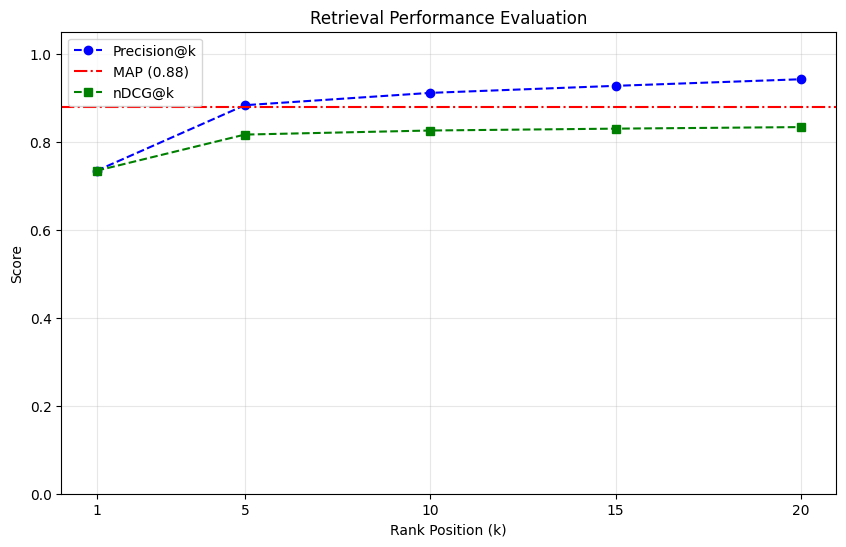

In [56]:
plot_evaluation_results(train_eval, [1, 5, 10, 15, 20])

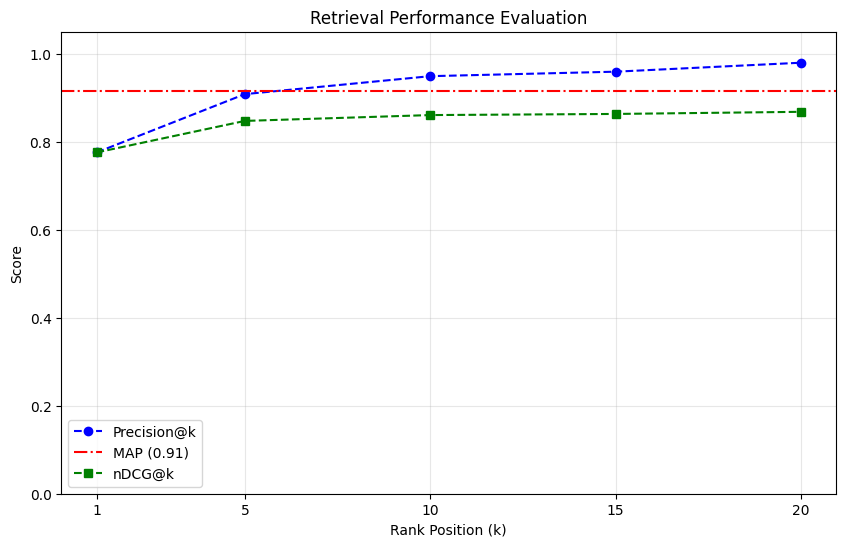

In [58]:
plot_evaluation_results(test_eval, [1, 5, 10, 15, 20])

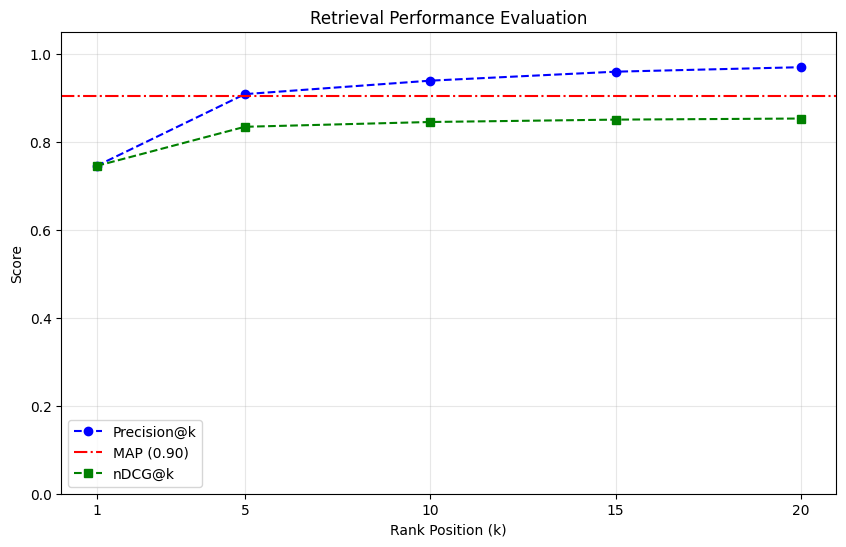

In [57]:
plot_evaluation_results(test_exp_eval, [1, 5, 10, 15, 20])